# А/В тестирование

## Содержание

1. [Постановка задачи](#step1)
2. [Tехническое задание](#step2)
3. [Загрузка и подготовка данных](#step3)
4. [Оценка корректности теста](#step4)
5. [Исследовательский анализ данных](#step5)
6. [А/В тест](#step6)
7. [Вывод](#step7)
8. [Рекомендации](#step8)

### Постановка задачи<a id="step1"></a>

Ваша задача — провести оценку результатов A/B-теста. В вашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

- Оцените корректность проведения теста
    
    проверьте:
    - пересечение тестовой аудитории с конкурирующим тестом,
    - совпадение теста и маркетинговых событий, другие проблемы временных границ теста.

- Проанализируйте результаты теста

### Техническое задание<a id="step2"></a>

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Загрузим данные<a id="step3"></a>

Загрузим библеотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
from datetime import timedelta, datetime
import math as mth
from plotly import graph_objects as go
import plotly.express as px
import plotly.graph_objs as go
from matplotlib import style
import os
import warnings
warnings.filterwarnings('ignore')

**Загрузим `final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.**

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

In [2]:
final_ab_events = pd.read_csv('**********************************')
final_ab_events

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [3]:
final_ab_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [4]:
# преобразуем дату
final_ab_events['event_dt'] = pd.to_datetime(final_ab_events['event_dt'])

In [5]:
# проверим на наличие дубликатов
final_ab_events.duplicated().sum()

0

In [6]:
# проверим на пропуски
final_ab_events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [7]:
final_ab_events['user_id'].nunique()

58703

In [8]:
final_ab_events.groupby('event_name').count()

,user_id,event_dt,details
event_name,,,
login,189552,189552,0
product_cart,62462,62462,0
product_page,125563,125563,0
purchase,62740,62740,62740


Мы загрузили файл, преобразовали дату. Проверили на дубликаты и пропуски. В файле 440317 записей и 58703 уникальных пользователя.

**Загрузим `ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.**

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

In [9]:
ab_project_marketing_events = pd.read_csv('**********************************')
ab_project_marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [10]:
ab_project_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [11]:
# преобразуем дату
ab_project_marketing_events['start_dt'] = pd.to_datetime(ab_project_marketing_events['start_dt'])
ab_project_marketing_events['finish_dt'] = pd.to_datetime(ab_project_marketing_events['finish_dt'])

In [12]:
print('Минимальная дата start_dt - ', ab_project_marketing_events['start_dt'].min())
print('Максимальная дата start_dt - ', ab_project_marketing_events['start_dt'].max())
print()
print('Минимальная дата finish_dt - ', ab_project_marketing_events['finish_dt'].min())
print('Максимальная дата finish_dt - ', ab_project_marketing_events['finish_dt'].max())

Минимальная дата start_dt -  2020-01-25 00:00:00
Максимальная дата start_dt -  2020-12-30 00:00:00

Минимальная дата finish_dt -  2020-02-07 00:00:00
Максимальная дата finish_dt -  2021-01-07 00:00:00


Мы загрузили файл. В нем 14 уникальных записи. Преобразовали дату. Посмотрели min и max значения в столбцах `start_dt` и `finish_dt`

**Загрузим `final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.**

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [13]:
final_ab_new_users = pd.read_csv('**********************************')
final_ab_new_users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [14]:
final_ab_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [15]:
# преобразуем дату
final_ab_new_users['first_date'] = pd.to_datetime(final_ab_new_users['first_date'])

In [16]:
# проверим на пропуски
final_ab_new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [17]:
# проверим на дубликаты
final_ab_new_users.duplicated().sum()

0

In [18]:
# посмотрим количество уникальных значений
final_ab_new_users['user_id'].nunique()

61733

In [19]:
# посмотрим на значения в столбце region
final_ab_new_users['region'].value_counts()

EU           46270
N.America     9155
CIS           3155
APAC          3153
Name: region, dtype: int64

In [20]:
# посмотрим на значения в столбце device
final_ab_new_users['device'].value_counts()

Android    27520
PC         15599
iPhone     12530
Mac         6084
Name: device, dtype: int64

In [21]:
print('Минимальная дата -', final_ab_new_users['first_date'].min())
print('Максимальная дата -', final_ab_new_users['first_date'].max())

Минимальная дата - 2020-12-07 00:00:00
Максимальная дата - 2020-12-23 00:00:00


Мы загрузили файл, проверили на пропуски и дубликаты. Посмотрели на распределение значений по столбцам `region` и `device`. В файле 61733 записи уникальных пользователей. Даты лежат в промежутке с 07.12.2020 по 23.12.2020. Это на 2 дня дольше, чем написано в анотации к данным.

**Загрузим данных `final_ab_participants.csv` — таблица участников тестов.**

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [22]:
final_ab_participants = pd.read_csv('**********************************')
final_ab_participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


In [23]:
final_ab_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [24]:
# проверим на пропуски
final_ab_participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [25]:
# проверим на дубликаты
final_ab_participants.duplicated().sum()

0

In [26]:
# подсчитаем число уникальных значений
final_ab_participants.nunique()

user_id    16666
group          2
ab_test        2
dtype: int64

Мы загрузили файл и проверили его на пропуски и дубликаты. В файле 18268 записей и 16666 уникальных пользователя. Это значит, что часть пользователей (1602) принимает участие в обоих тестах. 

## Оценим корректность проведения теста:<a id="step4"></a>

* Соответствие данных требованиям технического задания. Проверьте корректность всех пунктов технического задания.
* Время проведения теста. Убедитесь, что оно не совпадает с маркетинговыми и другими активностями.
* Аудиторию теста. Удостоверьтесь, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверьте равномерность распределения по тестовым группам и правильность их формирования.

**Проверим наши данные на соответствие техническому заданию.**

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**Проверим на соответствие даты запуска и остановки набора новых пользователей.**

In [27]:
final_ab_new_users['first_date'].describe()

count                   61733
unique                     17
top       2020-12-21 00:00:00
freq                     6290
first     2020-12-07 00:00:00
last      2020-12-23 00:00:00
Name: first_date, dtype: object

Дата начала совпадает, а дата конца на 2 дня больше.
Удалим данные выходящие из указанного в задании временного диапазона.

In [28]:
final_ab_new_users_clin = final_ab_new_users.query('first_date >= "2020-12-07" and first_date <= "2020-12-21"')

Посмотрим на количество удаленных данных

In [29]:
print('Мы удалили {} записей. Что составляет {:,.2%} от общего значения.'
      .format(len(final_ab_new_users) - len(final_ab_new_users_clin), 
             (len(final_ab_new_users) - len(final_ab_new_users_clin)) / len(final_ab_new_users)))

Мы удалили 5263 записей. Что составляет 8.53% от общего значения.


**Проверим условие: дата остановки теста: 2021-01-04**

In [30]:
final_ab_events['event_dt'].describe()

count                  440317
unique                 267268
top       2020-12-14 18:54:55
freq                       10
first     2020-12-07 00:00:33
last      2020-12-30 23:36:33
Name: event_dt, dtype: object

Здесь представлен временной промежуток с 07.12.2020 по 30.12.2020. Это на 4 дня меньше, чем написано в техзадании. Очевидно из-за новогодних праздников логи событий с 31.12.2020 по 04.01.2021 не были записаны.
Оставляем как есть.

Получается, что часть пользователей не проживут положенного срока в 14 дней и их придется удалить.

**Проверим наших пользователей на лайфтайм равный 14 дням и удалим лишнее.**

Объединим два датафрейма. Получим датафрейм с данными о пользователях которые совершали какие-то действия. Пользователи зарегистрировшиеся, но не совершавшие действия, будут удалены.

In [31]:
# объединим два датафрейма
users = final_ab_events.merge(final_ab_new_users_clin, on='user_id')

# заведем новый столбец
users['life_time'] = (users['event_dt'] - users['first_date']).round('D')

# посчитаем количество уникальных пользователей
size_users_old = len(users.groupby('user_id').nunique())

In [32]:
# удалим данные превышающие наш lifetime
users = users[users['life_time'] < '14 days']

# посчитаем количество уникальных пользователей
size_users = len(users.groupby('user_id').nunique())

users

,user_id,event_dt,event_name,details,first_date,region,device,life_time
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,2020-12-07,N.America,iPhone,1 days
1,E1BDDCE0DAFA2679,2020-12-09 06:21:35,purchase,9.99,2020-12-07,N.America,iPhone,2 days
3,E1BDDCE0DAFA2679,2020-12-07 20:22:03,login,NaN,2020-12-07,N.America,iPhone,1 days
4,E1BDDCE0DAFA2679,2020-12-09 06:21:35,login,NaN,2020-12-07,N.America,iPhone,2 days
6,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,EU,iPhone,0 days
...,...,...,...,...,...,...,...,...
407742,FE2F3BFF12E5AB13,2020-12-21 09:42:43,login,NaN,2020-12-21,EU,Mac,0 days
407743,FE2F3BFF12E5AB13,2020-12-23 10:19:10,login,NaN,2020-12-21,EU,Mac,2 days
407744,FE2F3BFF12E5AB13,2020-12-24 09:28:54,login,NaN,2020-12-21,EU,Mac,3 days
407745,7836B9BF6BC33911,2020-12-21 19:49:46,login,NaN,2020-12-21,EU,Android,1 days


Оценим объем удаленных данных

In [33]:
print('В датафрейме {} уникальных пользователя.'.format(size_users))
print('Мы удалили {} записей. Это {:.2%} от общего.'.format(size_users_old - size_users, 
                                                       (size_users_old - size_users) / size_users_old))

В датафрейме 53429 уникальных пользователя.
Мы удалили 11 записей. Это 0.02% от общего.


**Проверим пересечение нашего теста с маркетинговыми событиями.**

In [34]:
ab_project_marketing_events.sort_values('start_dt')

,name,regions,start_dt,finish_dt
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01
4,4th of July Promo,N.America,2020-07-04,2020-07-11
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07


В наш тест попадают два маркетинговых события - `Christmas&New Year Promo` и `CIS New Year Gift Lottery`. Посмотрим как это повлияло  на активность пользователей. Событие `CIS New Year Gift Lottery` проходит в регионе CIS где очень мало наших клиентов и затрагивает только 1 день нашего теста, так что его можно не принимать в расчет. Событие  `Christmas&New Year Promo` может повлиять на наш тест. Оно проходит в регионе, где больше всего наших клиентов и включает последние 5 дней нашего теста.

**Проверим группы А и В на пересечение пользователей.**

In [35]:
# посмотрим на состав группы
final_ab_participants['ab_test'].value_counts()

interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

In [36]:
# сравним с количеством уникальных пользователей
print('В файле представлены данные {} пользователей, {} из них уникальны.'
      .format(len(final_ab_participants['user_id']), final_ab_participants['user_id'].nunique()))

В файле представлены данные 18268 пользователей, 16666 из них уникальны.


Оценим объем данных подлежищих удалению.

Мы выяснили, что 1602 пользователя принимают участие в обоих тестах. Для нас важна чистота группы В в нашем тесте, т.к. если они попали только в контрольную группу (А) - это значит, что тест interface_eu_test никак на них не повлиял. Оценим количество пользователей участвующих в обоих тестах и находящихся в группе В , для их последующего удаления. 

In [37]:
# посчитаем пользователей кто участвовал в interface_eu_test
user_recommender_system_test = final_ab_participants.query('ab_test == "recommender_system_test" ')['user_id'].nunique()

# создадим список пользователей состоящих в обоих тестах в группе В
mask_B = (final_ab_participants.query('group == "B"')
                               .groupby('user_id')
                               .agg({'ab_test' : 'nunique'})
                               .query('ab_test == 2')
                               .reset_index())
#mask = final_ab_participants.groupby('user_id').agg({'ab_test' : 'nunique'}).query('ab_test == 2').reset_index()
mask_list = mask_B['user_id'].tolist()

# удаляем пресекающиеся данные
final_ab_participants_test = final_ab_participants.query('ab_test == "recommender_system_test"')
final_ab_participants_clin = final_ab_participants_test.query('user_id != @mask_list')
# посчитаем число пользователей после удаления
temp = len(final_ab_participants_clin.groupby('user_id')['user_id'].nunique())

print('Число пользователей теста recommender_system_test -', user_recommender_system_test)
print('Число пользователей теста recommender_system_test после удаления ', temp)
print('Мы удалили - {:.1%} данных'.format((user_recommender_system_test - temp) / user_recommender_system_test))

Число пользователей теста recommender_system_test - 6701
Число пользователей теста recommender_system_test после удаления  6357
Мы удалили - 5.1% данных


Объединим фатафреймы и посмотрим на распределение в нем.

In [38]:
data = final_ab_participants_clin.merge(users, on='user_id')
data

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device,life_time
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC,1 days
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,NaN,2020-12-07,EU,PC,1 days
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,NaN,2020-12-07,EU,PC,1 days
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,login,NaN,2020-12-07,EU,PC,1 days
4,A7A3664BD6242119,A,recommender_system_test,2020-12-20 15:46:06,product_page,NaN,2020-12-20,EU,iPhone,1 days
...,...,...,...,...,...,...,...,...,...,...
23070,6715343AFBA285AE,B,recommender_system_test,2020-12-07 10:12:15,login,NaN,2020-12-07,CIS,Android,0 days
23071,6715343AFBA285AE,B,recommender_system_test,2020-12-08 22:51:16,login,NaN,2020-12-07,CIS,Android,2 days
23072,6715343AFBA285AE,B,recommender_system_test,2020-12-09 02:28:03,login,NaN,2020-12-07,CIS,Android,2 days
23073,6715343AFBA285AE,B,recommender_system_test,2020-12-10 22:55:14,login,NaN,2020-12-07,CIS,Android,4 days


In [39]:
data['user_id'].nunique()

3569

In [40]:
# посмотрим на распределение по группам
data.groupby('group')['user_id'].nunique()


group
A    2747
B     822
Name: user_id, dtype: int64

Группы распределены неравномерно. В группах А и В нет пересекающихся пользователей. После объединения датафреймов у нас количество участников в тесте снизилось с 6357 до 3569, в 1.8 раза. Очевидно, что большая часть участников теста были зарегистрированы, но не совершали никаких действий, поэтому и не вошли в итоговый датафрейм.

**Проверим аудиторию.** 

По условию 15%  новых пользователей должны быть из региона EU.

Посчитаем долю новых пользователей из EU.

In [41]:
# возьмем отфильтрованные по дате данные о новых пользователях и отфильтруем их по региону
final_ab_new_users_clin_EU = final_ab_new_users_clin.query('region == "EU"')

# выделим участников теста recommender_system_test
user_recommender_system_test = final_ab_participants.query('ab_test == "recommender_system_test" ')

# объединим их
users_merge = user_recommender_system_test.merge(final_ab_new_users_clin_EU, on='user_id')

# посчитаем количество пользователей
temp_EU = users_merge['user_id'].nunique()

# посчитаем всех новых пользователей
temp_all = final_ab_new_users_clin['user_id'].nunique()

print('Всего новых пользователей {}. Пользователей из EU участвующих в тесте {}. Это {:.1%} от общего количества.'
      .format(temp_all, temp_EU, temp_EU / temp_all))

Всего новых пользователей 56470. Пользователей из EU участвующих в тесте 6351. Это 11.2% от общего количества.


Доля новых пользователей из региона EU в тесте ниже чем в техзадании.

### Предварительный вывод

- группы: А - контрольная (2747), B - новая платёжная воронка (822). Группы распределены неравномерно. Всего в тесте принимает участие 3569 человек. Это в 1.7 раза меньше значения из техзадания. *Условие не соблюдено.*
- дата запуска: 2020-12-07. *Условие соблюдено.*
- дата остановки набора новых пользователей: 2020-12-21. После удаления лишних данных *условие соблюдено.*
- дата остановки: 2021-01-04. Тест фактически заканчивается 2021-12-30. *Условие не соблюдено.*
- аудитория: 15% новых пользователей из региона EU. Доля новых пользователей из EU составляет только 11.2%. Это меньше значения из техзадания. *Условие не соблюдено.*

## Исследовательский анализ данных<a id="step5"></a>

 Проведем исследовательский анализ данных:
 
* Количество событий на пользователя одинаково распределены в выборках?
* Как число событий в выборках распределено по дням?
* Как меняется конверсия в воронке в выборках на разных этапах?
* Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

**Количество событий на пользователя для каждой из групп.**

In [42]:
users_A = data.query('group=="A"').groupby('user_id')['event_name'].count().reset_index()
users_A

,user_id,event_name
0,0010A1C096941592,12
1,00341D8401F0F665,2
2,003DF44D7589BBD4,15
3,00505E15A9D81546,5
4,006E3E4E232CE760,6
...,...,...
2742,FF44696E39039D29,6
2743,FF5A1CD38F5DD996,10
2744,FF5B24BCE4387F86,9
2745,FF825C1D791989B5,8


In [43]:
users_B = data.query('group=="B"').groupby('user_id')['event_name'].count().reset_index()
users_B

,user_id,event_name
0,005E096DBD379BCF,4
1,015D1E3BB893349D,6
2,015FF3EC72C1F4F6,2
3,01B0B891CA513468,12
4,01C17F099908DA14,5
...,...,...
817,FE76759FE6BF8C68,16
818,FE8F9858BBE502D9,2
819,FEA0C585A53E7027,3
820,FF8CF7057415EB29,4


In [44]:
users_A.describe()

,event_name
count,2747.000000
mean,6.809246
std,3.797210
min,1.000000
25%,4.000000
50%,6.000000
75%,9.000000
max,24.000000


In [45]:
users_B.describe()

,event_name
count,822.000000
mean,5.316302
std,3.157606
min,1.000000
25%,3.000000
50%,4.000000
75%,6.000000
max,24.000000


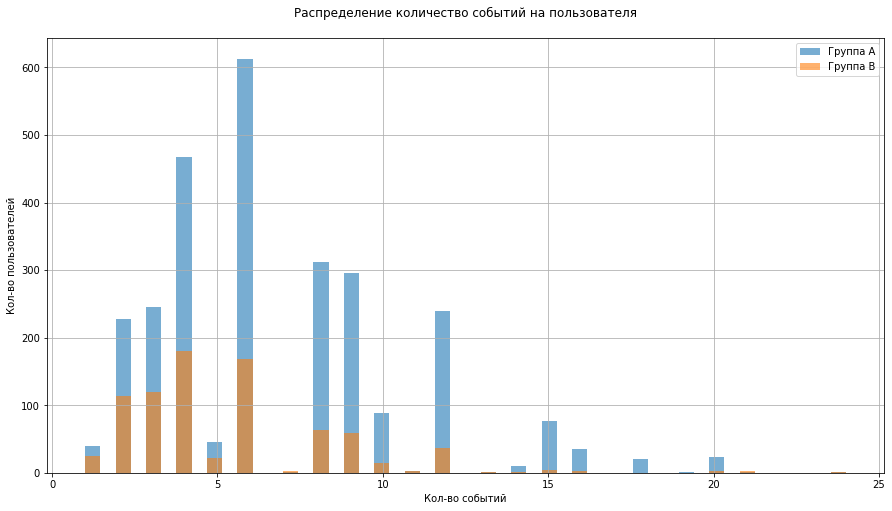

In [46]:
# построим гистограмму
users_A['event_name'].hist(bins=50, figsize=(15,8), label='Группа A', alpha=0.6);
users_B['event_name'].hist(bins=50, label='Группа B', alpha=0.6)
plt.legend()
plt.xlabel('Кол-во событий')
plt.ylabel('Кол-во пользователей')
plt.title('Распределение количество событий на пользователя\n');

Динамика распределения событий примерно равна между двух групп.

**Как число событий в выборке распределено по дням.**

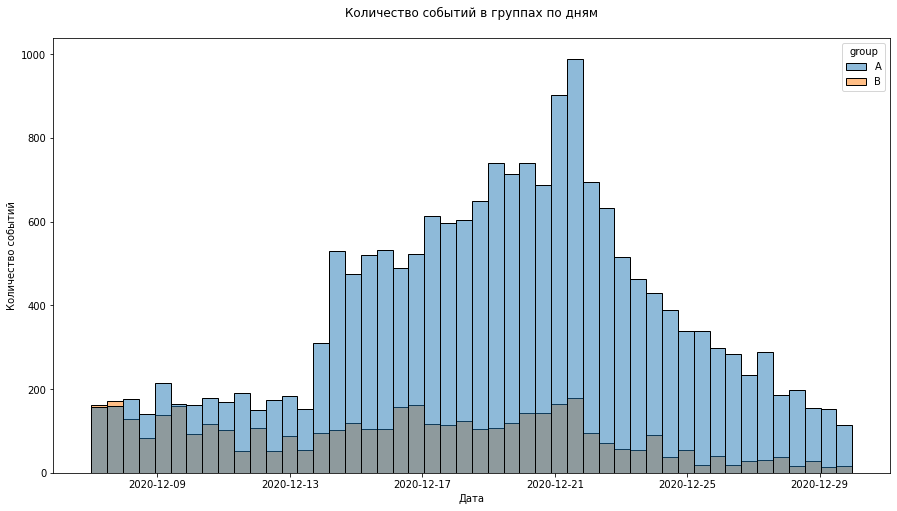

In [47]:
plt.figure(figsize=(15, 8))
plt.title('Количество событий в группах по дням\n')
sns.histplot(data, x='event_dt', hue='group')
plt.xlabel('Дата')
plt.ylabel('Количество событий');

Из графика видно, что у группы А с 14.12.2020 наблудается резкий скачек количества событий примерно в 2 раза с дальнейшим повышением. Максимум приходится на 21.12.2020 с дальнейшим уменьшением до нормальных значений к 29.12.2020. Может это влияние рождественских распродаж, а может технический сбой. Группа В ведет себя более равномерно. Это еще раз показывает, что время для проведения А/В теста выбрано неудачно. 

**Как меняется конверсия в воронке в выборках на разных этапах.**

In [48]:
# посмотрим на количество пользователей в группах
funnel = (data.groupby(['group','event_name'])
              .agg({'user_id':('count', 'nunique')})
              .sort_values(by = ('user_id', 'count'), ascending = False)
              .reset_index())

funnel.columns = ['group', 'event_name', 'count', 'nunique']
funnel

,group,event_name,count,nunique
0,A,login,8294,2747
1,A,product_page,5344,1780
2,A,purchase,2588,872
3,A,product_cart,2479,824
4,B,login,2139,821
5,B,product_page,1127,459
6,B,product_cart,567,225
7,B,purchase,537,226


In [49]:
# разделим таблицу по группам и добавим столбец с процентами
funnel_A = funnel.query('group == "A"')
temp = funnel_A['nunique'].shift(1)
temp[0] = funnel_A.loc[0,'nunique']
funnel_A['percent'] = (funnel_A['nunique']/temp[0]*100).round(1)
funnel_A['percent2'] = (funnel_A['nunique']/temp*100).round(1)
funnel_A

,group,event_name,count,nunique,percent,percent2
0,A,login,8294,2747,100.0,100.0
1,A,product_page,5344,1780,64.8,64.8
2,A,purchase,2588,872,31.7,49.0
3,A,product_cart,2479,824,30.0,94.5


Самым распространенным событием является login - регистрация в программе. Мы видим как теряются пользователи от шага к шагу. Больше всего теряется на втором шаге, при переходе к `product_cart`.

In [50]:
funnel_B = funnel.query('group == "B"').reset_index(drop=True)
temp = funnel_B['nunique'].shift(1)
temp[0] = funnel_B.loc[0,'nunique']
funnel_B['percent'] = (funnel_B['nunique']/temp[0]*100).round(1)
funnel_B['percent2'] = (funnel_B['nunique']/temp*100).round(1)
funnel_B

,group,event_name,count,nunique,percent,percent2
0,B,login,2139,821,100.0,100.0
1,B,product_page,1127,459,55.9,55.9
2,B,product_cart,567,225,27.4,49.0
3,B,purchase,537,226,27.5,100.4


Самым распространенным событием является login - регистрация в программе. Мы видим как теряются пользователи от шага к шагу. Больше всего теряется на втором шаге, при переходе к `product_cart`. На последнем шаге мы видим прибавление пользователей из-за возможности перейти сразу к `purchase` минуя другие шаги.

#### Выводы:

Сравнивая конверсия в просмотр карточек товаров мы видим.
* событие product_page: группа А - 64.8%,   группа В - 55.9%   --- ухудшение
* событие product_cart: группа А - 31.7%,   группа В - 27.4%   --- ухудшение
* событие purchase:     группа А - 30.0%,   группа В - 27.5%   --- ухудшение

В ходе теста мы не увидели ожидаемый эффект в улучшение каждой метрики не менее чем на 10%. Все метрики показали ухудшение конверсии. 

Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

Мы видим многочисленные нарушения при проведении А/В теста.
* группы различны по количеству: А - контрольная (2082), B - новая платёжная воронка (706). Допускается не более 1%.
* тест фактически закончился на 4 дня раньше срока. Часть пользователей не успела "прожить" 14 дней.
* в период проведения теста приходится на рождество и на проведение крупное маркетингового события. 

## Проведем А/В тест<a id="step6"></a>

Сформируем гипотезы:
Нулевая гипотеза - Между долями пользователей группы А и В в шагах `product_page`, `product_cart`, `purchase` нет статистически значимой разницы.
Альтернативная гипотеза - Доли пользователей группы А и В различны.

Напишем функцию для расчета теста.

In [51]:
def z_test (fact1, fact2, name):
    
    total1 = funnel_A.loc[0,'nunique']
    total2 = funnel_B.loc[0,'nunique']
     
    # пропорция событий в первой группе:
    p1 = fact1 / total1
    # пропорция событий во второй группе:
    p2 = fact2 / total2
    # пропорция событий в комбинированном датасете:
    p_comb = (fact1 + fact2) / (total1 + total1)
    # разница пропорций в датасетах
    delta = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = delta / np.sqrt(p_comb * (1 - p_comb) * (1/total1 + 1/total2))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  
    # считаем p-value
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    # критический уровень статистической значимости
    alpha = 0.05
    # используем поправку Бонферрони для множественных сравнений
    bon_alpha = alpha / 3
    
    print()
    print('Событие', name)
    print()
    print('p-значение: ',p_value)
    
    if (p_value < bon_alpha):
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    
    print('Конверсия в группе A равна', p1.round(2))
    print('Конверсия в группе B равна', p2.round(2))
    print()

In [52]:
for i in range(1,4):
    
    fact1 = funnel_A.loc[i,'nunique']
    fact2 = funnel_B.loc[i,'nunique']
    name = funnel_A.loc[i,'event_name']
    z_test (fact1, fact2, name)


Событие product_page

p-значение:  5.393798344188738e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница
Конверсия в группе A равна 0.65
Конверсия в группе B равна 0.56


Событие purchase

p-значение:  0.00636558838532042
Отвергаем нулевую гипотезу: между долями есть значимая разница
Конверсия в группе A равна 0.32
Конверсия в группе B равна 0.27


Событие product_cart

p-значение:  0.114397488834864
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Конверсия в группе A равна 0.3
Конверсия в группе B равна 0.28



**Предварительный вывод.**

* статистической разницы в конверсии в покупки `purchase` между группами нет;
* есть статистически значимые различия в конверсии в просмотр товаров `product_page` и в просмотр корзины `product_cart`.
* внедрение новой рекомендательной системы негативно повлияла на процесс выбора товаров.

## Вывод<a id="step7"></a>

* В ходе исследования мы загрузили данные и обработали их.
* Оценили корректность проведения теста. Мы обнаружили.
    - группы: А - контрольная (2747), B - новая платёжная воронка (822). Группы распределены неравномерно. Всего в тесте принимает участие 3569 человек. Это в 1.7 раза меньше значения из техзадания. *Условие не соблюдено.
    - дата запуска: 2020-12-07. *Условие соблюдено.*
    - дата остановки набора новых пользователей: 2020-12-21. После удаления лишних данных *условие соблюдено.*
    - дата остановки: 2021-01-04. Тест фактически заканчивается 2021-12-30. *Условие не соблюдено.*
    - аудитория: 15% новых пользователей из региона EU. Доля новых пользователей из EU составляет только 11.2%. Это меньше значения из техзадания. *Условие не соблюдено.*
* Провели исследовательский анализ данных. Мы увидели.
    * Динамика распределения количества событий на пользователя в группах примерно равна между собой.
    * При сравнении графиков распределяния числа событий по дням мы обнаружили:
        * у группы А с 14.12.2020 наблудается резкий скачек количества событий примерно в 2 раза с дальнейшим повышением.
        * Максимум приходится на 21.12.2020 с дальнейшим уменьшением до нормальных значений к 29.12.2020. 
        * Может это влияние рождественских распродаж, а может технический сбой. 
        * Группа В ведет себя более равномерно.
    * Сравнивая конверсия в просмотр карточек товаров мы посчитали.
        * событие product_page: группа А - 64.8%,   группа В - 55.9%   --- ухудшение
        * событие product_cart: группа А - 31.7%,   группа В - 27.4%   --- ухудшение
        * событие purchase:     группа А - 30.0%,   группа В - 27.5%   --- ухудшение
* Провели А/В тест.
    * статистической разницы в конверсии в покупки `purchase` между группами нет;
    * есть статистически значимые различия в конверсии в просмотр товаров `product_page` и в просмотр корзины `product_cart`.
    * внедрение новой рекомендательной системы негативно повлияла на процесс выбора товаров.

## Рекомендации<a id="step8"></a>

Данный тест нельзя считать репрезентативным. Он выполнен с многочисленными нарушениями технического задания.
Необходимо переделать тест.